# Introduction

This notebook displays a 'reimplementation' of the Reno-Hansen method from PVLib.  The original implementation from PVLib makes it difficult to extract numerical values for computed metrics.  This implementation also has some minor differences in the way clear points are labelled.  In Reno-Hansen, all points inside of a clear window were labelled as clear (even if they were in a different window labelled as unclear).  In this implementation, we assign clarity only to the central index of the window.  This will lead to fewer points being labelled clear in this reimplementaiton, but shouldn't have a dramatic effect.

At this time, iterative fitting is missing from the reimplementation.

# Imports, configs, etc

In [21]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load irradiance data

## SNL

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [22]:
file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
cols = ['Global_Wm2', 'Date-Time']
rtc_data = pd.read_csv(file, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
rtc_data.index = rtc_data.index.tz_localize('Etc/GMT+7')
rtc_data = rtc_data.reindex(
    pd.date_range(start=rtc_data.index[0], end=rtc_data.index[-1], freq='1min')
).fillna(0)
rtc_data = pd.Series(rtc_data['Global_Wm2'], index=rtc_data.index)
rtc_data[rtc_data < 0] = 0

## NREL SRRL BMS

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/.  This data is being used because it was already downloaded for a different notebook.  Irradiance data is also measured on a minute-to-minute basis.

# Set up PVLib system

## SNL

In [23]:
rtc_azimuth = 180
rtc_elevation = 1658
rtc_tilt = 35
rtc_lat = 35.0549
rtc_lon = -106.5433

In [24]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=rtc_tilt, surface_azimuth=rtc_azimuth)
rtc_loc = pvlib.location.Location(rtc_lat, rtc_lon, altitude=rtc_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

## NREL SRRL BMS

In [25]:
srrl_lat = 39.742
srrl_lon = -105.18
srrl_tilt = 40
srrl_azimuth = 180
srrl_elevation = 1828.8

In [26]:
srrl_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=srrl_tilt, surface_azimuth=srrl_azimuth)
srrl_loc = pvlib.location.Location(srrl_lat, srrl_lon, altitude=srrl_elevation)
srrl = pvlib.pvsystem.LocalizedPVSystem(pvsystem=srrl_no_loc, location=srrl_loc)

# Analysis

In [27]:
def pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~pvlib_is_clear], sample[is_clear & ~pvlib_is_clear], 
               facecolor='none', edgecolor='green', label='model free')
    _ = ax.scatter(sample.index[pvlib_is_clear & ~is_clear], sample[pvlib_is_clear & ~is_clear], 
               facecolor='none', edgecolor='red', label='pvlib')
    _ = ax.scatter(sample.index[pvlib_is_clear & is_clear], sample[is_clear & pvlib_is_clear], 
               facecolor='none', edgecolor='yellow', label='both')
    _ = ax.legend()
    
    # ax = axes[1]
    # _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='model free')
    # _ = ax.plot(pvlib_is_clear.index, np.cumsum(pvlib_is_clear.astype(int)), label='pvlib')
    # _ = ax.legend()
    
    tmp_df = pd.DataFrame()
    
    tmp_df['this_work'] = is_clear
    tmp_df['pvlib'] = pvlib_is_clear
    
    tmp_df = tmp_df.resample('D').sum()
    tmp_df.index = tmp_df.index.date
    
    tmp_df.plot(kind='bar', ax=axes[1])
    
    fig.tight_layout()

## Samples from SNL

In [28]:
rtc_sample = rtc_data[(rtc_data.index >= '2016-07-01') & (rtc_data.index < '2016-08-01')]

In [29]:
rtc_clear_skies = rtc.get_clearsky(rtc_sample.index)
rtc_clear_skies = pd.Series(rtc_clear_skies['ghi'], index=rtc_sample.index)

Get pvlib clear sky times for comparison using standard/default parameters.

In [30]:
rtc_pvlib_is_clear, _, alpha = pvlib.clearsky.detect_clearsky(rtc_sample, rtc_clear_skies, 
                                                              rtc_sample.index, 10, return_components=True)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


In [31]:
alpha

0.93136819756149969

### Standard method

In [32]:
rtc_bhe_is_clear, component_dict = clearsky_detect_model_free.model_comparison(rtc_sample, rtc_clear_skies, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:404: RuntimeWarning: invalid value encountered in double_scalars
  return std_dy / window_mean


<IPython.core.display.Javascript object>


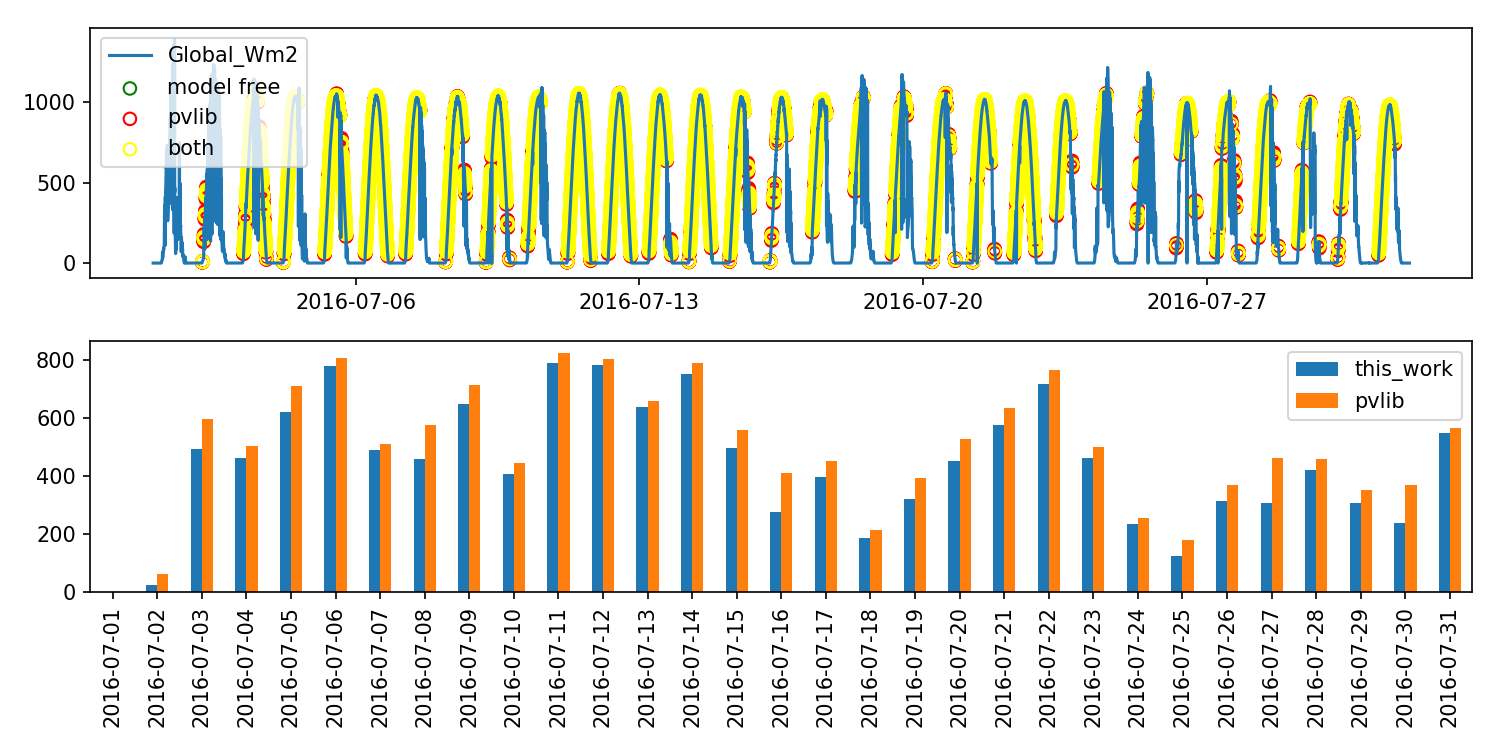

In [33]:
pvlib_compare_plot(rtc_sample, rtc_clear_skies, rtc_bhe_is_clear, rtc_pvlib_is_clear)

In [34]:
components = component_dict['component_vals']

In [35]:
components.keys()

Index(['meas_avg', 'model_avg', 'meas_max', 'model_max', 'meas_line_length',
       'model_line_length', 'meas_slope_std', 'model_slope_std',
       'max_slope_dev'],
      dtype='object')

<IPython.core.display.Javascript object>


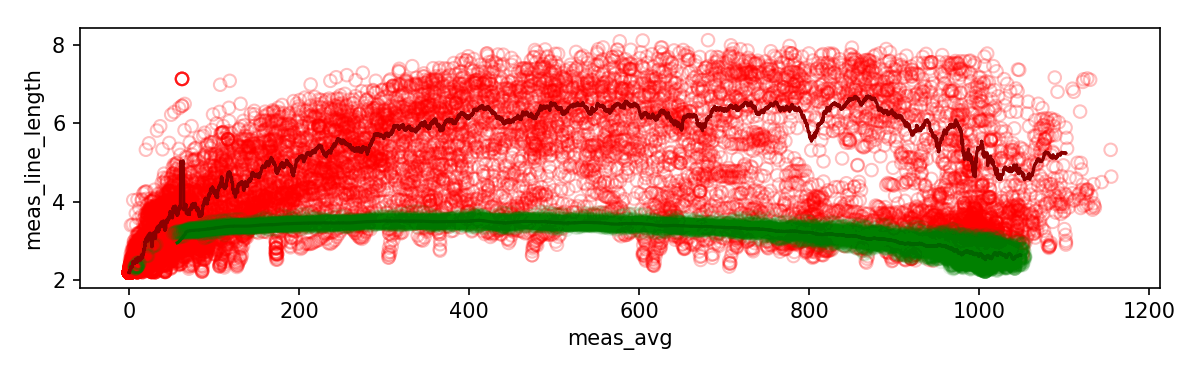

In [36]:
components['clear'] = rtc_bhe_is_clear
clear_df = components[components['clear']].copy()
cloudy_df = components[~components['clear']].copy()
fig, ax = plt.subplots(figsize=(8, 2.5))

x, y = 'meas_avg', 'meas_line_length'
ax.scatter(cloudy_df[x], np.log(cloudy_df[y]), edgecolor='red', facecolor='none', alpha=.25)
ax.scatter(clear_df[x], np.log(clear_df[y]), edgecolor='green', facecolor='none', alpha=.1)
cloudy_df = cloudy_df.sort_values('meas_avg')
ax.plot(cloudy_df[x], np.log(cloudy_df[y].rolling(100, center=True).mean()), c='darkred')
clear_df = clear_df.sort_values('meas_avg')
ax.plot(clear_df[x], np.log(clear_df[y].rolling(100, center=True).mean()), c='darkgreen')
ax.set_xlabel(x)
ax.set_ylabel(y)

fig.tight_layout()

<IPython.core.display.Javascript object>


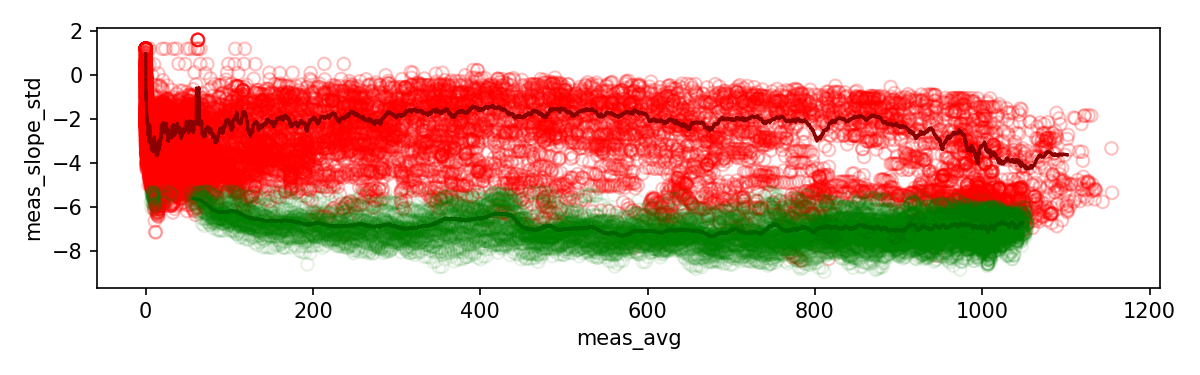

In [37]:
components['clear'] = rtc_bhe_is_clear
clear_df = components[components['clear']].copy()
cloudy_df = components[~components['clear']].copy()
fig, ax = plt.subplots(figsize=(8, 2.5))

x, y = 'meas_avg', 'meas_slope_std'
ax.scatter(cloudy_df[x], np.log(cloudy_df[y]), edgecolor='red', facecolor='none', alpha=.25)
ax.scatter(clear_df[x], np.log(clear_df[y]), edgecolor='green', facecolor='none', alpha=.1)
cloudy_df = cloudy_df.sort_values('meas_avg')
ax.plot(cloudy_df[x], np.log(cloudy_df[y].rolling(100, center=True).mean()), c='darkred')
clear_df = clear_df.sort_values('meas_avg')
ax.plot(clear_df[x], np.log(clear_df[y].rolling(100, center=True).mean()), c='darkgreen')
ax.set_xlabel(x)
ax.set_ylabel(y)

fig.tight_layout()

<IPython.core.display.Javascript object>


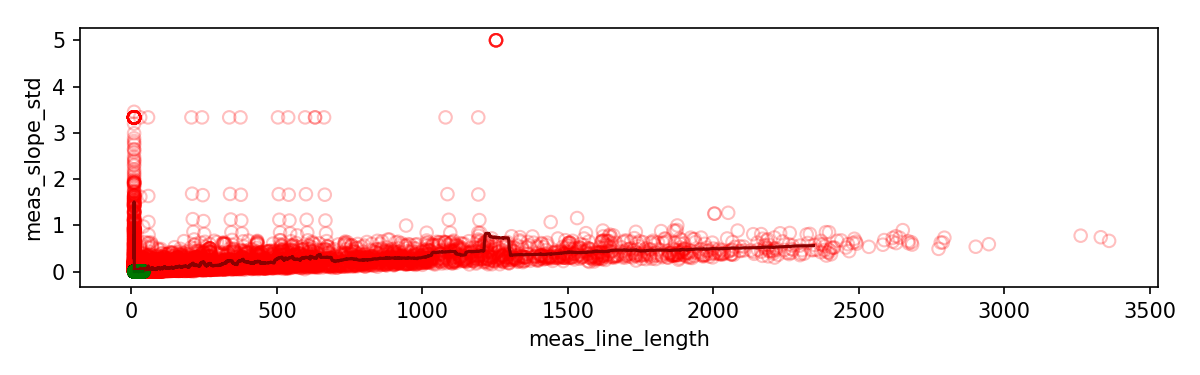

In [38]:
components['clear'] = rtc_bhe_is_clear
clear_df = components[components['clear']].copy()
cloudy_df = components[~components['clear']].copy()
fig, ax = plt.subplots(figsize=(8, 2.5))

x, y = 'meas_line_length', 'meas_slope_std'
ax.scatter(cloudy_df[x], (cloudy_df[y]), edgecolor='red', facecolor='none', alpha=.25)
ax.scatter(clear_df[x], (clear_df[y]), edgecolor='green', facecolor='none', alpha=.1)
cloudy_df = cloudy_df.sort_values('meas_line_length')
ax.plot(cloudy_df[x], (cloudy_df[y].rolling(100, center=True).mean()), c='darkred')
clear_df = clear_df.sort_values('meas_line_length')
ax.plot(clear_df[x], (clear_df[y].rolling(100, center=True).mean()), c='darkgreen')
ax.set_xlabel(x)
ax.set_ylabel(y)

fig.tight_layout()

<IPython.core.display.Javascript object>


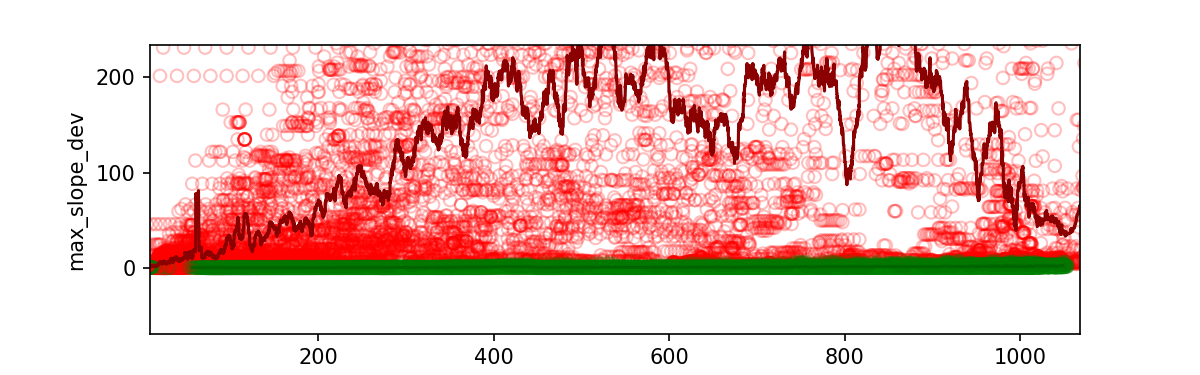

In [39]:
components['clear'] = rtc_bhe_is_clear
clear_df = components[components['clear']]
cloudy_df = components[~components['clear']]
fig, ax = plt.subplots(figsize=(8, 2.5))

x, y = 'meas_avg', 'max_slope_dev'
ax.scatter(cloudy_df[x], (cloudy_df[y]), edgecolor='red', facecolor='none', alpha=.25)
ax.scatter(clear_df[x], (clear_df[y]), edgecolor='green', facecolor='none', alpha=.1)
cloudy_df = cloudy_df.sort_values('meas_avg')
ax.plot(cloudy_df[x], (cloudy_df[y].rolling(100, center=True).mean()), c='darkred')
clear_df = clear_df.sort_values('meas_avg')
ax.plot(clear_df[x], (clear_df[y].rolling(100, center=True).mean()), c='darkgreen')
ax.set_xlabel(x)
ax.set_ylabel(y)

## Samples from NREL SRRL BMS

In [ ]:
srrl_sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-01-08')]

In [ ]:
srrl_clear_skies = srrl.get_clearsky(srrl_sample.index)
srrl_clear_skies = pd.Series(srrl_clear_skies['ghi'], index=srrl_sample.index)

In [ ]:
cs_srrl_is_clear, cs_srrl_result = clearsky_detect_model_free.model_free_detect(srrl_clear_skies, verbose=True)

Get pvlib clear sky times for comparison using standard/default parameters.

In [ ]:
srrl_pvlib_is_clear = pvlib.clearsky.detect_clearsky(srrl_sample, srrl_clear_skies, srrl_sample.index, 10)

### Standard method

In [ ]:
srrl_mf_is_clear, srrl_result = clearsky_detect_model_free.model_free_detect(srrl_sample, verbose=True)

In [ ]:
pvlib_compare_plot(srrl_sample, srrl_clear_skies, srrl_mf_is_clear, srrl_pvlib_is_clear)

The standard model-free based approach is more generous than PVLib methods.  The model-free approach also fails at some fairly obvious locations (July 1st mid-late day, July 4th late day).

### Democratic method

In [ ]:
srrl_mf_is_clear, srrl_result = clearsky_detect_model_free.model_free_detect_democratic(srrl_sample, verbose=True)

In [ ]:
pvlib_compare_plot(srrl_sample, srrl_clear_skies, srrl_mf_is_clear, srrl_pvlib_is_clear)

### Mean method

In [ ]:
srrl_mf_is_clear, srrl_result = clearsky_detect_model_free.model_free_detect_meanval(srrl_sample, verbose=True)

In [ ]:
pvlib_compare_plot(srrl_sample, srrl_clear_skies, srrl_mf_is_clear, srrl_pvlib_is_clear)

# Conclusions

We saw the SNL results in a previous notebook, they were just repeated here for easy comparison with SRRL data.  The model free approach works much better than the PVLib approach **for the same parameters** between SNL and SRRL sites.  The PVLib method could likely be finely tuned to give much better results